# 30 Day Kaggle Challenge
## Competition Phase


## Initialize Data

In [193]:
#Import the important packages
import pandas as pd
import numpy as np
import os, datetime

#Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

#Validation Fix
from sklearn.model_selection import train_test_split

#Model Quality Fix
from sklearn.metrics import mean_squared_error
# for root mean squared error rmse
#rms = mean_squared_error(y, X, squared= False)
from sklearn.model_selection import cross_val_score

#Bundling Fix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#NaN Fix
from sklearn.impute import SimpleImputer

#Categorical/Object Data Fix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [194]:
#Get and Display current working directory
cwd = os.getcwd()

#Change Directory to parent (one step up)
filepath_elements = cwd.split('/')
filepath_elements.pop()
filepath= '/'.join(filepath_elements)
filepath

#Save filenames and path as str in variables
datapath = '/30-days-of-ml/'
dataname_test = 'test.csv'
dataname_train = 'train.csv'
dataname_samplesubmit = 'sample_submission.csv'

#Read the csv files and initialize as Dataframes
data_test = pd.read_csv(filepath+datapath+dataname_test, index_col='id')
data_train = pd.read_csv(filepath+datapath+dataname_train, index_col='id')
data_samplesubmit = pd.read_csv(filepath+datapath+dataname_samplesubmit, index_col='id')

#Display Data for viewing
data_samplesubmit.head(10);
data_train.head(10);
data_test.head(10);

#Getting Columns
train_cols = list(data_train.columns)
print(train_cols);
test_cols = list(data_test.columns)
print(test_cols);
train_cats = [col for col in train_cols if 'cat' in col]
train_conts = [col for col in train_cols if 'cont' in col]
test_cats = [col for col in test_cols if 'cat' in col]
test_conts = [col for col in test_cols if 'cont' in col]

#Inspect for NaNs
print(data_train.isnull().sum().sum())
data_train.isnull().any();
print(data_test.isnull().sum().sum())
data_test.isnull().any();

#Inspect categorical data for cardinality
cardinals_train = list(map(lambda col: data_train[col].nunique(), train_cats))
save_cardinals_train = dict(zip(train_cats, cardinals_train))
sorted(save_cardinals_train.items(), key=lambda x: x[1]);

cardinals_test = list(map(lambda col: data_test[col].nunique(), test_cats))
save_cardinals_test = dict(zip(train_cats, cardinals_test))
sorted(save_cardinals_test.items(), key=lambda x: x[1]);

#filter low cardinality columns
filter_limit = 10

low_cardinality_categorical_cols = [col for col in data_train.columns if data_train[col].nunique()<filter_limit and data_train[col].dtype == 'object']

#filter only numerical columns
numerical_cols = train_conts.copy()

#get columns to be used 
selected_cols = low_cardinality_categorical_cols + numerical_cols


['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'target']
['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
0
0


## Build X and y set

In [195]:
#Get full X and full y from data_train and thus X_test from data_test

y_full = data_train.target.copy()

X_full = data_train[selected_cols].copy()

X_test = data_test[selected_cols].copy()

#X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2,
#                                                                random_state=0)

## Build Model via Pipelines; subsequently validate and generate predictions

In [196]:
#Make your pipelines

#Preprocessing for numerical data; no NaNs in data means not used though
numerical_transformer = SimpleImputer(strategy='constant')

numerical_stategies = ['constant', 'mean', 'median', 'most_frequent']

#Preprocessing for categorical data

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_strategies = ['most_frequent']

#Bundle Preprocessing together => numerical and categorical 

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, low_cardinality_categorical_cols)])

/Users/amitavchrismostafa/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/amitavchrismostafa/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type

{50: 0.7398295043696014, 150: 0.7401406103512024, 250: 0.742115200746976, 350: 0.7441890441540027, 450: 0.7464913188894856, 550: 0.748571870708295, 650: 0.7504128498697308, 750: 0.7524333650019376, 850: 0.7542366588799844, 950: 0.7560772037034437}


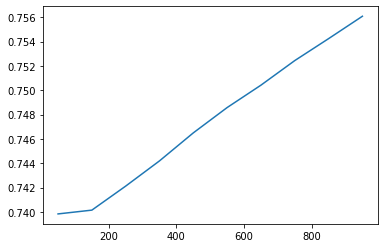

In [198]:
#With Decision Tree Regressor
def score_dtr(max_nodes):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor(max_leaf_nodes=max_nodes, random_state=1))
    ])
    score = np.sqrt(-1 * cross_val_score(pipeline1, X_full, y_full,
                                  cv=3,
                                  scoring='neg_mean_squared_error'))
    return score.mean()

results = {i:score_dtr(i) for i in range(50,1000,100) } 
print(results)

%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [ ]:
#Select best approach; Generate test predictions

final_dtr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor(max_leaf_nodes=max_nodes, random_state=1))
    ])

final_dtr.fit(y_full, X_full)
predict_dtr = final_dtr.predict(X_test)

output_dtr = pd.DataFrame ( {'Id':X_test.index, 'target':predict_test_dtr})
output_dtr.to_csv('submission_dtr.csv', index=False)


"si = SimpleImputer()\n\nidXt = pd.DataFrame(si.fit_transform(drop_X_test))\n\nidXt.columns = drop_X_test.columns\n\npredict_test = model.predict(idXt)\n\noutput = pd.DataFrame ( {'Id':X_test.index, 'SalePrice':predict_test})\noutput.to_csv('submission_nothappy_droppedcatvar_NaNinCatVar_cantimpute.csv', index=False)\n"